# <center> <font style="color:rgb(100,109,254)"> Feature Matching </font> </center>
We have seen how to detect features and compute its descriptors and now we will see how to match those descriptors across images, this will allow us to find one object in different images. There are a number of Feature matching methods so lets take a look at them.

In [2]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

## <font style="color:rgb(134,19,348)"> Brute-Force Matcher   </font>
First up its the Brute-Force matcher, as the name implies it takes a brute force approach. So it takes the descriptor of one feature in first set and matches it with all other features in second set using some distance calculation. And the closest one is returned.

[```bf = cv2.BFMatcher_create( [, normType[, crossCheck]] )```](https://docs.opencv.org/master/d3/da1/classcv_1_1BFMatcher.html#ac6418c6f87e0e12a88979ea57980c020)


**params**

- **normType**	It specifies the distance measurement to be used. By default, it is cv2.NORM_L2 other possible values are: NORM_L1, NORM_L2, NORM_HAMMING, NORM_HAMMING2. L1 and L2 norms are preferable choices for SIFT and SURF descriptors, NORM_HAMMING should be used with ORB, BRISK and BRIEF, NORM_HAMMING2 should be used with ORB when WTA_K==3 or 4 , by default WTA_K = 2 in ORB constructor.

- **crossCheck**  crossCheck is a is boolean variable which is false by default. If it is true, Matcher returns only those matches with value (i,j) such that i-th descriptor in set A has j-th descriptor in set B as the best match and vice-versa. That is, the two features in both sets should match each other. It provides consistent result, and is a good alternative to ratio test proposed by D.Lowe in SIFT paper.

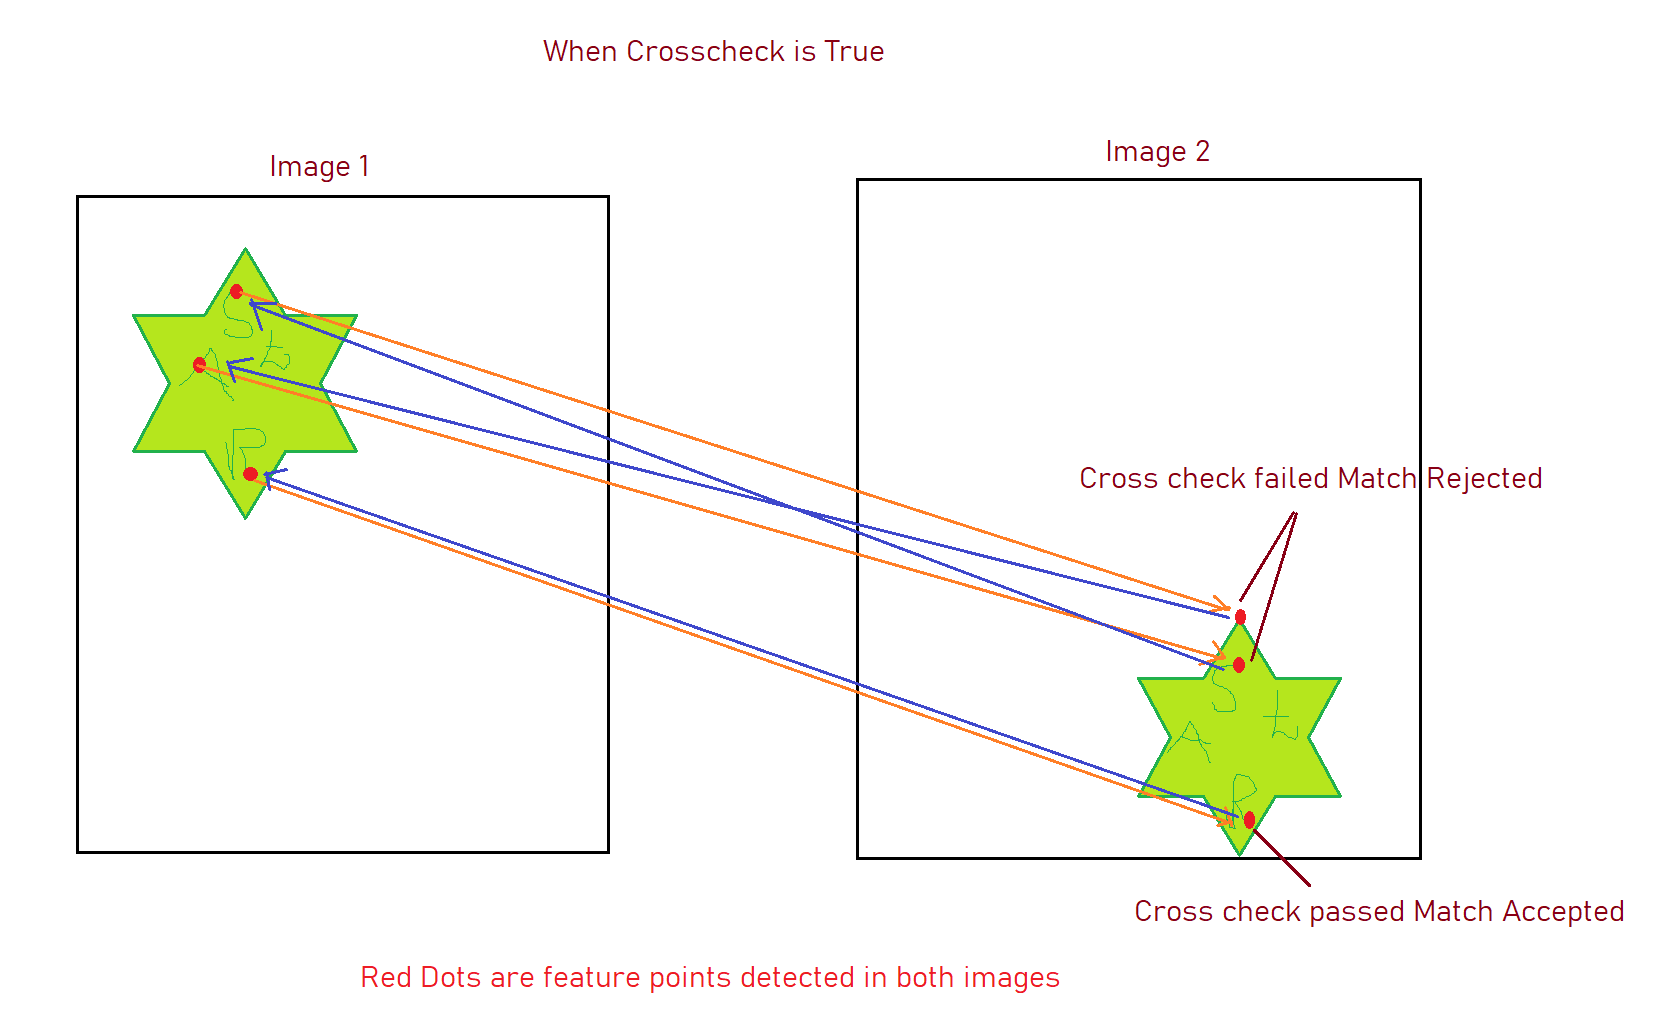

Once it is created, two important methods are BFMatcher.match() and BFMatcher.knnMatch(). First one returns the best match. Second method returns k best matches where k is specified by the user. It may be useful when we need to do additional work on that.

### In this notebook our goal will be to find *img1* inside *img2*, *img1* will be called the *query image* and *img2* will be called *train img*.

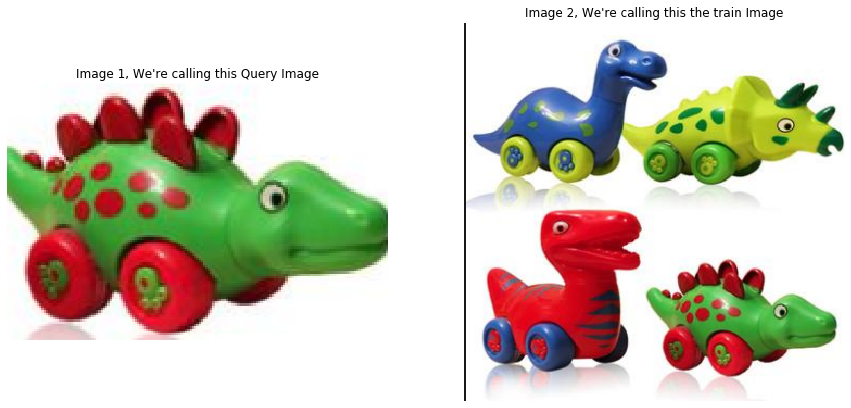

In [71]:
img1 = cv2.imread('media/M4/dino.png',1)  # queryImage
img2 = cv2.imread('media/M4/toys1.png',1) # trainImage

# Initialize ORB detector
orb = cv2.ORB_create()

# Find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

plt.figure(figsize=[15,15])
plt.subplot(121);plt.imshow(img1[...,::-1]);plt.title("Image 1, We're calling this Query Image"),plt.axis('off');
plt.subplot(122);plt.imshow(img2[...,::-1]);plt.title("Image 2, We're calling this the train Image"),plt.axis('off');

**We are setting crosscheck = True for now, we'll later see an example when crosscheck is false.**

In [72]:
# Create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
#bf = cv2.BFMatcher(crossCheck=True) # use this when using sift here so remove norm hamming flag

# Match descriptors.
matches = bf.match(des1,des2)

# Sorting them in order of their distances so we get the best matches first
matches = sorted(matches, key = lambda x:x.distance) 

### <font style="color:rgb(134,19,348)">  Drawing Matches   </font>

Just Like our **cv2.drawKeypoints()** which is used to draw keypoints, there is a  **cv2.drawMatches()** which helps us to draw the matches. It stacks two images horizontally and draw lines from first image to second image showing best matches. There is also **cv2.drawMatchesKnn()** which draws all the k best matches. If k=2, it will draw two match-lines for each keypoint. So we have to pass a mask if we want to selectively draw it.

```outImg = cv2.drawMatches( img1, keypoints1, img2, keypoints2, matches1to2, outImg[, matchColor[, singlePointColor[, matchesMask[, flags]]]])```


- **img1**	First source image.
- **keypoints1**	Keypoints from the first source image.
- **img2**	Second source image.
- **keypoints2**	Keypoints from the second source image.
- **matches1to2**	Matches from the first image to the second one, which means that keypoints1[i] has a corresponding point in keypoints2[matches[i]] .
- **outImg**	Output image. Its content depends on the flags value defining what is drawn in the output image. See possible flags bit values below.
- **matchColor**	Color of matches (lines and connected keypoints). By default color is generated randomly.
- **singlePointColor**	Color of single keypoints (circles), which means that keypoints do not have the matches. If - ---singlePointColor==Scalar::all(-1) , the color is generated randomly.
- **matchesMask**	Mask determining which matches are drawn. If the mask is empty, all matches are drawn.
- **flags**	Flags setting drawing features. Possible flags bit values are defined by [DrawMatchesFlags.](https://docs.opencv.org/master/d4/d5d/group__features2d__draw.html#ga2c2ede79cd5141534ae70a3fd9f324c8)

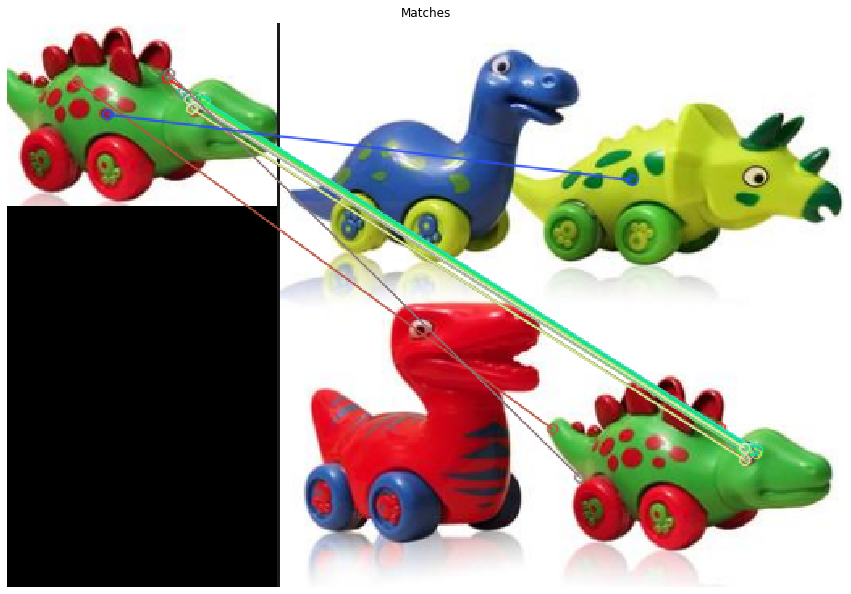

In [73]:
# Drawing only first 20 matches (Just for sake of visibility. You can increase it as you like)
matches_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None, flags=2)

plt.figure(figsize=[15,15])
plt.imshow(matches_img[...,::-1]);plt.title("Matches");plt.axis('off');

## <font style="color:rgb(134,19,348)">BF KNN Matcher with D.Lowe Ratio Test.    </font>


**bf.match(des1,des2)** returns  a list of DMatch objects. This DMatch object has following attributes:


- **DMatch.distance** - Distance between descriptors. The lower, the better it is.

- **DMatch.trainIdx** - Index of the descriptor in train descriptors

- **DMatch.queryIdx** - Index of the descriptor in query descriptors

- **DMatch.imgIdx** - Index of the train image.

This time, we will use **bf.knnMatch()** to get `k` best matches. In this example, we will take `k=2` so that we can apply ratio test explained by D.Lowe in his paper.

In ratio test we are simply checking the distance between 2 descriptors, the lower it is the better the match will be.

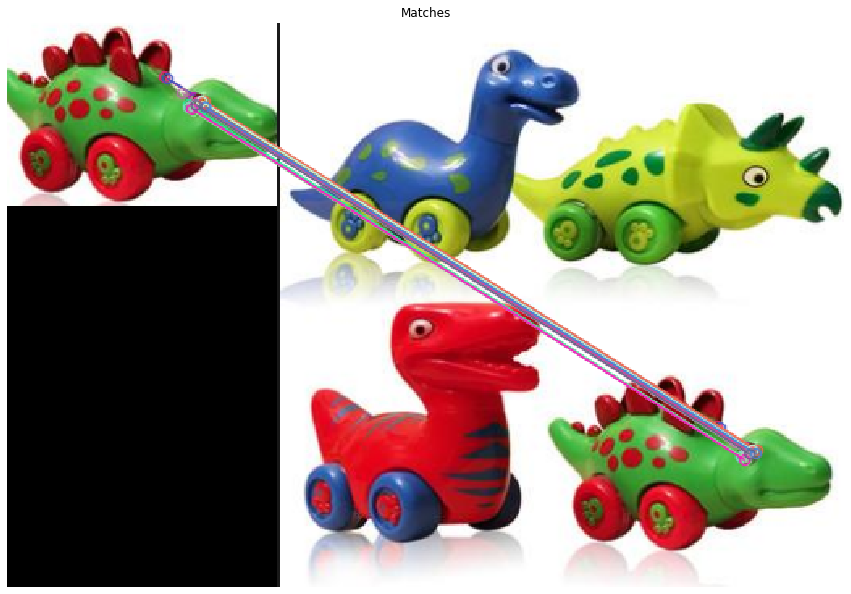

In [52]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test

# This will hold a list of all good matches.
good = []

# Unpack the values equal to the value of k
for m,n in matches:   
    # Lower the percentage to get even better matches
    if m.distance < 0.70*n.distance:
        good.append([m])
        
# Using cv2.drawMatchesKnn() same parmas as cv2.drawMatches().
matches_img = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags=2)

plt.figure(figsize=[15,15])
plt.imshow(matches_img[...,::-1]);plt.title("Matches");plt.axis('off');

# <font style="color:rgb(134,19,348)">  Flann based Matcher  </font>

FLANN stands for Fast Library for Approximate Nearest Neighbors. It contains a collection of algorithms optimized for fast nearest neighbor search in large datasets and for high dimensional features. It works faster than BFMatcher for large datasets. lets look at another example with FLANN based matcher.

**FLANN ALgorithms:**


|  **Algorithms**         | **ID**    |
|---------------------------|-------|
| FLANN_INDEX_LINEAR        | 0     |
| FLANN_INDEX_KDTREE        | 1     |
| FLANN_INDEX_KMEANS        | 2     |
| FLANN_INDEX_COMPOSITE     | 3     |
| FLANN_INDEX_KDTREE_SINGLE | 4     |
| FLANN_INDEX_HIERARCHICAL  | 5     |
| FLANN_INDEX_LSH           | 6     |
| FLANN_INDEX_SAVED         | 254   |
| FLANN_INDEX_AUTOTUNED     | 255   |


For FLANN based matcher, we need to pass two dictionaries which specifies the algorithm to be used, its related parameters etc.

```flann = cv2.FlannBasedMatcher( [, indexParams[, searchParams]] )```


- **IndexParams:** A dictionary, For various algorithms, the information to be passed is explained in FLANN docs

- **SearchParams:** A dictionary, It specifies the number of times the trees in the index should be recursively traversed. Higher values gives better precision, but also takes more time. If you want to change the value, pass search_params = dict(checks=100).


Resources:
- [FLANN tutorial Opencv](https://docs.opencv.org/2.4/modules/flann/doc/flann_fast_approximate_nearest_neighbor_search.html)
- [Paper on Flann](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.160.1721&rep=rep1&type=pdf)
- [Flann Tutorial](https://www.cs.ubc.ca/research/flann/uploads/FLANN/flann_manual-1.8.4.pdf)

###  <font style="color:rgb(134,19,348)">Flann Matcher with ORB.    </font>
The values for index params are FLANN_INDEX_LSH specific (locality sensitive hashing, a type of FLANN algorithm) and are taken from opencv docs and seems to work well. To understand what these variables do look into the resources section.

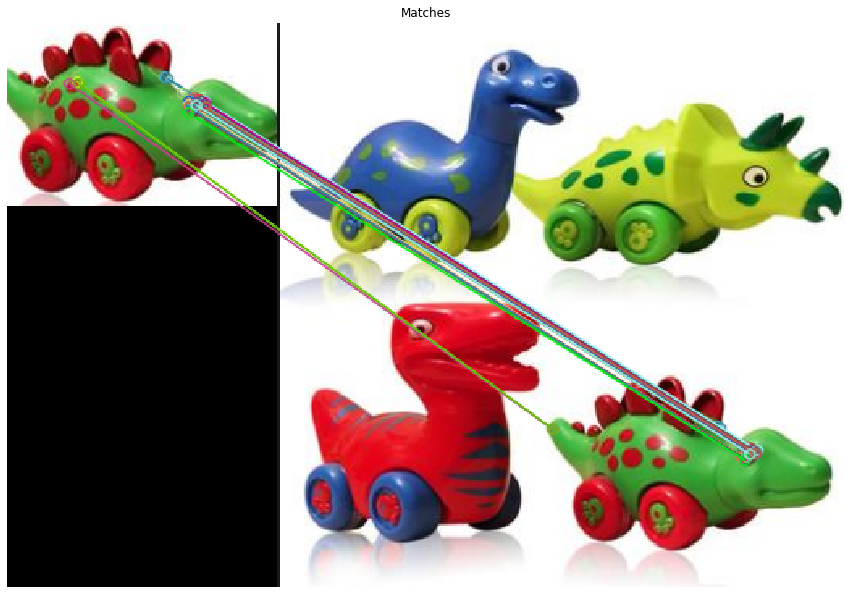

In [76]:
index_params= dict(algorithm = 6, table_number = 6, key_size = 12, multi_probe_level = 1)

# Since default value is 50 you can also pass in an empty dictionary.
search_params = dict(checks=50)   

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.70*n.distance:
        good.append([m])

matches_img = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=[15,15])
plt.imshow(matches_img[...,::-1]);plt.title("Matches");plt.axis('off');

**Note: If you're using SIFT or SURF with FLANN then set index_params as following.**

``` index_params = dict(algorithm = 1, trees = 5)```